In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
import sklearn
import seaborn as sns
import sklearn.cross_validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn import linear_model

In [2]:
url = 'Non_Eruption_Analysis_Updated.csv'
non_erupting = pd.read_csv(url)
non_erupting = non_erupting.drop('Unnamed: 0', axis=1)
#non_erupting.replace('Na',np.nan, inplace=True)
non_erupting['Eruption'] = 0
non_erupting.head()
#non_erupting.keys()


,Track No.,avg_len,len_slope,len_stdev,len_skew,avg_area,area_slope,avg_chirality,area_stdev,area_skew,...,tilt_slope,tilt_stdev,tilt_skew,avg_xcen,avg_ycen,avg_L_to_W,L_to_W_slope,L_to_W_stdev,L_to_W_skew,Eruption
0,64,1.502704e+10,-37783.834169,7.057940e+09,-0.517915,3575.378706,-0.016387,-0.285714,2848.097304,0.024285,...,-0.000059,44.387399,-1.996380,-270.365144,352.830139,0.568988,2.180691e-07,0.077561,0.892376,0
1,78,7.836976e+09,-6102.033443,6.143945e+09,1.128764,933.652078,-0.001189,0.222222,826.875587,0.959604,...,0.000016,6.363917,-0.401543,306.587871,602.257324,1.168775,5.264839e-07,0.134269,-0.295441,0
2,98,6.517520e+09,1037.898365,2.951724e+09,0.784306,1405.966521,-0.000139,-0.083333,939.852408,0.860860,...,-0.000028,31.682651,0.548083,-68.863906,751.834671,1.359917,9.163294e-07,0.419225,0.571166,0
3,106,9.973610e+09,4492.250739,4.727834e+09,0.536195,1624.553214,0.002209,-0.266667,1101.857303,0.629189,...,0.000019,35.201224,1.513316,49.039162,402.727268,1.352262,9.239087e-07,0.502687,-0.326030,0
4,135,5.473693e+09,-3938.969362,2.801293e+09,0.813839,514.624842,0.000302,-0.142857,387.273975,0.987636,...,0.000050,33.124493,-0.700079,-76.338799,-274.691999,1.437599,1.252587e-06,0.650604,-0.677931,0


In [3]:
url = 'Eruption_Analysis_Updated.csv'

erupting = pd.read_csv(url)
erupting = erupting.drop('Unnamed: 0', axis=1)
#erupting.replace('Na',np.nan, inplace=True)
erupting = erupting.astype(float)
erupting['Eruption'] = 1
erupting = erupting.dropna()
erupting.head()

,Track No.,avg_len,len_slope,len_stdev,len_skew,avg_area,area_slope,avg_chirality,area_stdev,area_skew,...,tilt_slope,tilt_stdev,tilt_skew,avg_xcen,avg_ycen,avg_L_to_W,L_to_W_slope,L_to_W_stdev,L_to_W_skew,Eruption
0,2,9.235591e+09,-3318.847179,4.719764e+09,0.331922,1096.087085,-0.000501,-0.142857,649.915228,1.117098,...,0.000019,5.578701,-0.572575,185.844144,426.017713,2.528948,8.112376e-07,0.515202,-0.438115,1
1,21,4.233401e+09,-3301.151011,7.508346e+08,0.778914,406.428664,-0.000413,0.000000,117.529374,-0.055259,...,0.000327,58.593676,0.784443,-439.171745,329.000000,0.777862,-9.742141e-07,0.370526,0.505928,1
2,58,6.285527e+09,-14242.892568,3.976058e+09,0.532748,1372.983516,-0.003546,0.400000,1136.174186,0.730185,...,0.000109,14.510152,0.986719,-14.090422,680.316602,0.713528,1.894434e-06,0.258048,0.381963,1
3,93,9.655840e+09,-18001.523983,1.100131e+10,1.947158,3532.892874,-0.012692,-0.142857,6174.080589,2.020256,...,-0.000114,52.196091,0.383411,-172.326899,656.900129,1.219291,-1.265216e-06,0.455738,1.385877,1
4,94,2.051227e+10,-41452.149693,6.950779e+09,-0.305232,5151.553005,-0.009953,0.250000,2129.620185,0.535753,...,-0.000116,72.680738,-0.749395,80.834544,303.171875,0.524115,1.527499e-06,0.269581,2.036469,1


# Running various K-S tests to see which parameters may be good to test

In [4]:
#KS test for filament length
erupt_len = erupting['avg_len'].tolist()
nerupt_len = non_erupting['avg_len'].tolist()
stats.ks_2samp(erupt_len, nerupt_len)

Ks_2sampResult(statistic=0.11632518175809653, pvalue=0.57217473610418967)

In [5]:
#KS test for change in length (slope)
erupt_slen = erupting['len_slope'].tolist()
nerupt_slen = non_erupting['len_slope'].tolist()
stats.ks_2samp(erupt_slen, nerupt_slen)

Ks_2sampResult(statistic=0.13707865168539335, pvalue=0.36230097458142696)

In [6]:
erupt_area = erupting['avg_area'].tolist()
nerupt_area = non_erupting['avg_area'].tolist()
stats.ks_2samp(erupt_area, nerupt_area)

Ks_2sampResult(statistic=0.10879048248512879, pvalue=0.65717162776033577)

In [7]:
#KS test for change in area (slope)
erupt_sarea = erupting['area_slope'].astype(float).tolist()
nerupt_sarea = non_erupting['area_slope'].astype(float).tolist()
stats.ks_2samp(erupt_sarea, nerupt_sarea)

Ks_2sampResult(statistic=0.18625247851949778, pvalue=0.086317756392148073)

In [8]:
erupt_chiral = erupting['avg_chirality'].tolist()
nerupt_chiral = non_erupting['avg_chirality'].tolist()
stats.ks_2samp(erupt_chiral, nerupt_chiral)

Ks_2sampResult(statistic=0.18466622604097821, pvalue=0.091042427442407842)

In [9]:
erupt_schiral = erupting['chirality_slope'].astype(float).tolist()
nerupt_schiral = non_erupting['chirality_slope'].astype(float).tolist()
stats.ks_2samp(erupt_schiral, nerupt_schiral)

Ks_2sampResult(statistic=0.2816920026437541, pvalue=0.0015099036406154283)

In [10]:
erupt_tilt = erupting['avg_tilt'].tolist()
nerupt_tilt = non_erupting['avg_tilt'].tolist()
stats.ks_2samp(erupt_tilt, nerupt_tilt)

Ks_2sampResult(statistic=0.15254461335095837, pvalue=0.24248608117708959)

In [11]:
erupt_stilt = erupting['tilt_slope'].dropna().astype(float).tolist()
nerupt_stilt = non_erupting['tilt_slope'].dropna().astype(float).tolist()
stats.ks_2samp(erupt_stilt, nerupt_stilt)

Ks_2sampResult(statistic=0.17131526768010574, pvalue=0.14000153591888387)

# Preparing for random forest classifier by putting erupting/nonerupting data together

In [12]:
##Now lets see if we can predict whether a filament will erupt or not. 
#erupting = erupting.astype(float)
all_eruptions=erupting.append(non_erupting)#,ignore_index = True)   #adding everything together
#all_eruptions = all_eruptions.dropna() #for now, dropping everything with NaN
all_eruptions.head()

,Track No.,avg_len,len_slope,len_stdev,len_skew,avg_area,area_slope,avg_chirality,area_stdev,area_skew,...,tilt_slope,tilt_stdev,tilt_skew,avg_xcen,avg_ycen,avg_L_to_W,L_to_W_slope,L_to_W_stdev,L_to_W_skew,Eruption
0,2,9.235591e+09,-3318.847179,4.719764e+09,0.331922,1096.087085,-0.000501,-0.142857,649.915228,1.117098,...,0.000019,5.578701,-0.572575,185.844144,426.017713,2.528948,8.112376e-07,0.515202,-0.438115,1
1,21,4.233401e+09,-3301.151011,7.508346e+08,0.778914,406.428664,-0.000413,0.000000,117.529374,-0.055259,...,0.000327,58.593676,0.784443,-439.171745,329.000000,0.777862,-9.742141e-07,0.370526,0.505928,1
2,58,6.285527e+09,-14242.892568,3.976058e+09,0.532748,1372.983516,-0.003546,0.400000,1136.174186,0.730185,...,0.000109,14.510152,0.986719,-14.090422,680.316602,0.713528,1.894434e-06,0.258048,0.381963,1
3,93,9.655840e+09,-18001.523983,1.100131e+10,1.947158,3532.892874,-0.012692,-0.142857,6174.080589,2.020256,...,-0.000114,52.196091,0.383411,-172.326899,656.900129,1.219291,-1.265216e-06,0.455738,1.385877,1
4,94,2.051227e+10,-41452.149693,6.950779e+09,-0.305232,5151.553005,-0.009953,0.250000,2129.620185,0.535753,...,-0.000116,72.680738,-0.749395,80.834544,303.171875,0.524115,1.527499e-06,0.269581,2.036469,1


In [13]:
all_eruptions['L_to_W_stdev'].describe()

count    174.000000
mean       0.376646
std        0.222125
min        0.046013
25%        0.214203
50%        0.316728
75%        0.491450
max        1.148806
Name: L_to_W_stdev, dtype: float64

In [14]:
#The random forest does a better job with values near 0 in general
#So here I am going to scale all of the values so they get closer to 0
all_eruptions['avg_len'] = all_eruptions['avg_len']/1e9
all_eruptions['len_slope'] = all_eruptions['len_slope']/1e3
all_eruptions['len_stdev'] = all_eruptions['len_stdev']/1e8
all_eruptions['avg_area'] = all_eruptions['avg_area']/100
all_eruptions['area_slope'] = all_eruptions['area_slope']*100
all_eruptions['area_stdev'] = all_eruptions['area_stdev']/100
all_eruptions['avg_chirality'] = all_eruptions['avg_chirality']*10
all_eruptions['chirality_slope'] = all_eruptions['chirality_slope']*1e6
all_eruptions['barb_slope'] = all_eruptions['barb_slope']*1e6
all_eruptions['tilt_slope'] = all_eruptions['tilt_slope']*1e4
all_eruptions['L_to_W_slope'] = all_eruptions['L_to_W_slope']*1e6
all_eruptions.head()

,Track No.,avg_len,len_slope,len_stdev,len_skew,avg_area,area_slope,avg_chirality,area_stdev,area_skew,...,tilt_slope,tilt_stdev,tilt_skew,avg_xcen,avg_ycen,avg_L_to_W,L_to_W_slope,L_to_W_stdev,L_to_W_skew,Eruption
0,2,9.235591,-3.318847,47.197644,0.331922,10.960871,-0.050083,-1.428571,6.499152,1.117098,...,0.188188,5.578701,-0.572575,185.844144,426.017713,2.528948,0.811238,0.515202,-0.438115,1
1,21,4.233401,-3.301151,7.508346,0.778914,4.064287,-0.041343,0.000000,1.175294,-0.055259,...,3.266641,58.593676,0.784443,-439.171745,329.000000,0.777862,-0.974214,0.370526,0.505928,1
2,58,6.285527,-14.242893,39.760582,0.532748,13.729835,-0.354642,4.000000,11.361742,0.730185,...,1.088524,14.510152,0.986719,-14.090422,680.316602,0.713528,1.894434,0.258048,0.381963,1
3,93,9.655840,-18.001524,110.013136,1.947158,35.328929,-1.269208,-1.428571,61.740806,2.020256,...,-1.144360,52.196091,0.383411,-172.326899,656.900129,1.219291,-1.265216,0.455738,1.385877,1
4,94,20.512269,-41.452150,69.507794,-0.305232,51.515530,-0.995295,2.500000,21.296202,0.535753,...,-1.156885,72.680738,-0.749395,80.834544,303.171875,0.524115,1.527499,0.269581,2.036469,1


In [15]:
#Pull out the feature we want to predict (1 for eruption, 0 for no eruption)
Y = np.array(all_eruptions['Eruption'])  #getting the eruption status (variable that is trying to be predicted)

In [16]:
all_eruptions.to_csv('All_Eruption_Analysis_Updated.csv', columns = ('Track No.', 'avg_len', 'len_slope', 'avg_area', 'area_slope', 'avg_chirality', 'chirality_slope', 'avg_barbs', 'barb_slope','avg_tilt', 'tilt_slope','avg_xcen','avg_ycen','avg_L_to_W','L_to_W_slope'))

In [17]:
#Now we need to remove that from our dataset. 
all_eruptions = all_eruptions.drop('Eruption',1)  #now dropping the eruption column! 

In [18]:
#Now we need to save all of the features as a matrix for the calucations later
X = all_eruptions.as_matrix()
print X

[[  2.00000000e+00   9.23559087e+00  -3.31884718e+00 ...,   8.11237628e-01
    5.15202369e-01  -4.38115396e-01]
 [  2.10000000e+01   4.23340084e+00  -3.30115101e+00 ...,  -9.74214111e-01
    3.70525916e-01   5.05927719e-01]
 [  5.80000000e+01   6.28552740e+00  -1.42428926e+01 ...,   1.89443366e+00
    2.58047689e-01   3.81962761e-01]
 ..., 
 [  2.81300000e+03   9.83662489e+00  -8.45597744e+00 ...,   5.61896352e-01
    6.61342203e-01   8.18583878e-02]
 [  2.89400000e+03   4.74463290e+00   5.10611378e+00 ...,  -5.20082079e-01
    1.88466573e-01   2.08099445e-01]
 [  2.94600000e+03   5.74020865e+00   2.01665744e+00 ...,  -3.83753247e-01
    1.48454490e-01  -2.52342979e-01]]


Our goal is to be able to predict the outcome (Y) by using the features (X)
Since we have a binary outcome, we want to use a classification scheme
Because of this, I am going to try to use a random forest classifier (I can send you details on what this is)
This is a good method when there is only a small sample (200 events is very small in data science)



In [90]:
#Let's start by making 40 different 'forests' (based on decision trees)
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score

n_trees = range(1,41)
scores = []
#This will make 40 forests, and each forest will be made up of 1-40 trees successively
#This way, we can see how much of an effect adding more trees has on the predictions.
for i in n_trees:
    forest = sklearn.ensemble.RandomForestClassifier(n_estimators = i)
    #val_score = cross_val_score(forest, X=X, y=Y, cv=10)
    val_score = cross_val_score(forest, X, Y, cv=StratifiedKFold(Y,10, shuffle=True)) #Try out a new type of scoring
    scores.append(val_score) 

0.611706495098


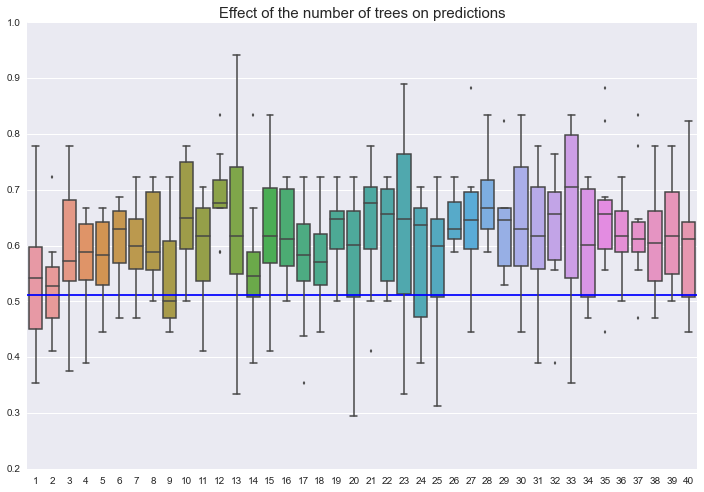

In [91]:
#How good at prediction is my tree? (I ran 40 different tests, so each bar is one test).
print np.mean(scores)
from matplotlib import pyplot as plt

plt.figure(figsize=(12,8))
plt.title('Effect of the number of trees on predictions', fontsize=15)
plt.axhline(y=1-avg)
#sns.boxplot(data=scores)
sns.boxplot(scores) #NOTE: Use this line if you have the older version of seaborn!!
plt.savefig("/home/nschanch/Downloads/test_img.png")
#Note: This is before correcting for the unbalanced sample size. 

In [87]:

#Let's start by making 40 different 'trees' (based on decisions)
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedKFold
#Unlike above, now we want to make 40 different forests, each conaining the same number of trees (15)
n_trees = [20]*40
scores = []
#This will make 40 forests, and each forest will be made up of 1-40 trees successively
#This way, we can see how much of an effect adding more trees has on the predictions.
for i in n_trees:
    forest = sklearn.ensemble.RandomForestClassifier(n_estimators = i)
    val_score = cross_val_score(forest, X, Y, cv=StratifiedKFold(Y,10, shuffle=True))
    #val_score = cross_val_score(forest, X=X, y=Y, cv=10)
    scores.append(val_score) 

0.615318627451


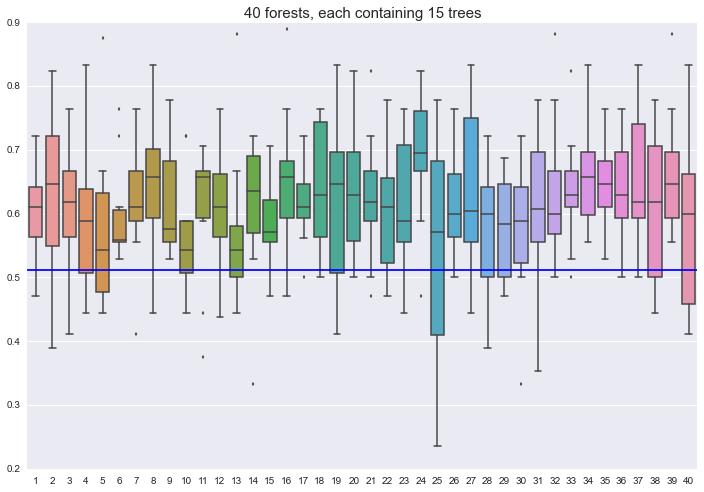

In [89]:
#How good at prediction is my tree? (I ran 40 different test, so each bar is one test).
print np.mean(scores)
from matplotlib import pyplot as plt

plt.figure(figsize=(12,8))
plt.title('40 forests, each containing 15 trees', fontsize=15)
sns.boxplot(scores)
plt.axhline(y=1-avg)
#sns.boxplot(data=scores)
#Note: This is before correcting for the unbalanced sample size. 

In [72]:
## your code here
non_erupt = 0.
for eruption in Y:
    if eruption == 0:
        non_erupt = non_erupt+1.
avg = non_erupt/len(Y)
print avg
print '%d percent of filaments do NOT erupt. Our sample is not quite balanced, but pretty close' % (avg*100)

0.488505747126
48 percent of filaments do NOT erupt. Our sample is not quite balanced, but pretty close


0.607819648693


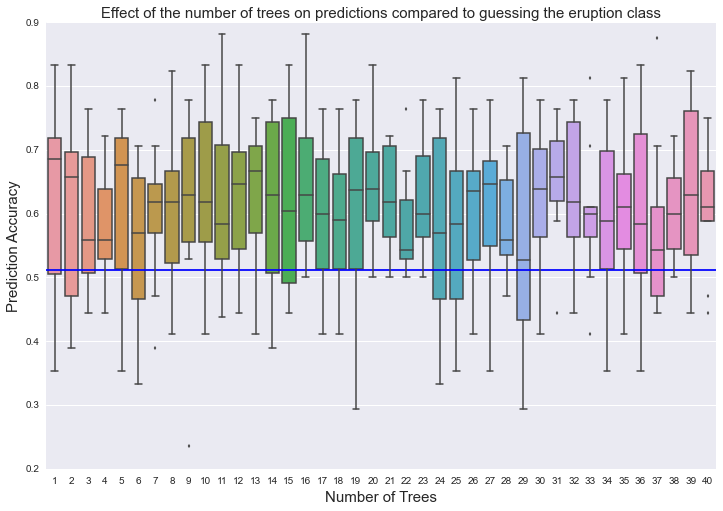

In [74]:
print np.mean(scores)
plt.figure(figsize=(12,8))
plt.axhline(y=1-avg)
plt.title('Effect of the number of trees on predictions compared to guessing the eruption class', fontsize=15)
plt.xlabel('Number of Trees', fontsize=15)
plt.ylabel('Prediction Accuracy', fontsize=15)
#sns.boxplot(data=scores)
sns.boxplot(scores)
plt.savefig('/home/nschanch/Desktop/random_forest_20_trees.png')

In [92]:
scores_2 = []
n_trees = [20]*40
for i in n_trees:
    forest_2 = sklearn.ensemble.RandomForestClassifier(n_estimators = i)
    #Same thing, but using a different type of scoring (f1)
    #The F1 score is defined as the harmonic mean of recall and precision
    #So this tries to balance how well it does at picking out all of the erupting filaments and how many erupting filaments it is correct about
    val_score_2 = cross_val_score(forest_2, X=X, y=Y, cv=StratifiedKFold(Y,10, shuffle=True), scoring='f1')
    scores_2.append(val_score_2) 

0.600397103782


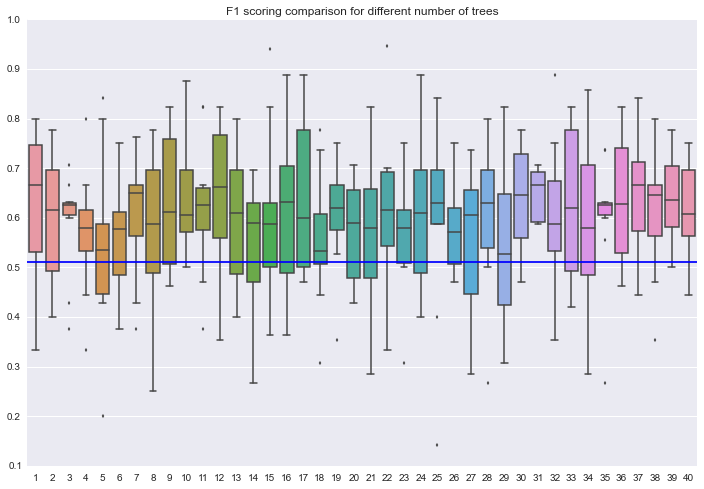

In [93]:
print np.mean(scores_2)
plt.figure(figsize=(12,8))
plt.title('F1 scoring comparison for different number of trees')
#sns.boxplot(data=scores)
sns.boxplot(scores_2)
plt.axhline(y=1-avg)

I don't really see a big difference between the two types of scoring...

In [27]:
#make the forest classifier and do that fit. Then find the probabilities
forest = sklearn.ensemble.RandomForestClassifier(n_estimators = 15)
fitted_forest = forest.fit(X, Y)
proba = fitted_forest.predict_proba(X)

#Make a prediction based on probabilities
class_predict = fitted_forest.predict(X)
print class_predict[:10]


#Now just make a prediction based on raw values of the probabilities
erupt_good = proba[:, 1]
sanity_predict = [0]*len(erupt_good)
print erupt_good[:10]
for i in range(len(sanity_predict)):
    if erupt_good[i] > 0.5:
        sanity_predict[i] = 1
    else:
        sanity_predict[i] = 0
        
        
print sanity_predict[:10]
#val_score = cross_val_score(forest, X=X, y=Y, cv=10)
#scores.append(val_score) 

(class_predict == sanity_predict).all()

[1 1 1 1 1 1 1 1 1 1]
[ 0.86666667  0.8         0.86666667  0.8         0.8         0.93333333
  0.86666667  0.73333333  0.8         0.86666667]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


True

In [38]:
from sklearn.cross_validation import StratifiedKFold, KFold
#Which features are leading to the good predictions?
feature_forest = sklearn.ensemble.RandomForestClassifier(n_estimators = 15)
#by_feature = feature_forest.feature_importances_
fitted_forest4a = feature_forest.fit(X, Y)
val_score_ = cross_val_score(fitted_forest4a, X=X, y=Y, cv=10)

val_score2_ = cross_val_score(fitted_forest4a, X=X,y=Y, cv=StratifiedKFold(Y,10))
imp_features = fitted_forest4a.feature_importances_
print val_score_
print val_score2_
print all_eruptions.keys()
print imp_features

[ 0.61111111  0.66666667  0.61111111  0.5         0.44444444  0.52941176
  0.35294118  0.70588235  0.76470588  0.5625    ]
[ 0.66666667  0.66666667  0.66666667  0.44444444  0.5         0.41176471
  0.47058824  0.64705882  0.64705882  0.5625    ]
Index([u'Track No.', u'avg_len', u'len_slope', u'len_stdev', u'len_skew',
       u'avg_area', u'area_slope', u'avg_chirality', u'area_stdev',
       u'area_skew', u'chirality_slope', u'avg_barbs', u'barb_slope',
       u'barb_stdev', u'barb_skew', u'avg_tilt', u'tilt_slope', u'tilt_stdev',
       u'tilt_skew', u'avg_xcen', u'avg_ycen', u'avg_L_to_W', u'L_to_W_slope',
       u'L_to_W_stdev', u'L_to_W_skew'],
      dtype='object')
[ 0.02797337  0.02954978  0.03221079  0.03869428  0.0757264   0.03905146
  0.04739368  0.03858417  0.04253213  0.03693687  0.08856472  0.03440566
  0.04854474  0.03655188  0.0394914   0.03132191  0.03436353  0.02798265
  0.01844327  0.04886584  0.04558755  0.03080473  0.02842472  0.04200313
  0.03599135]


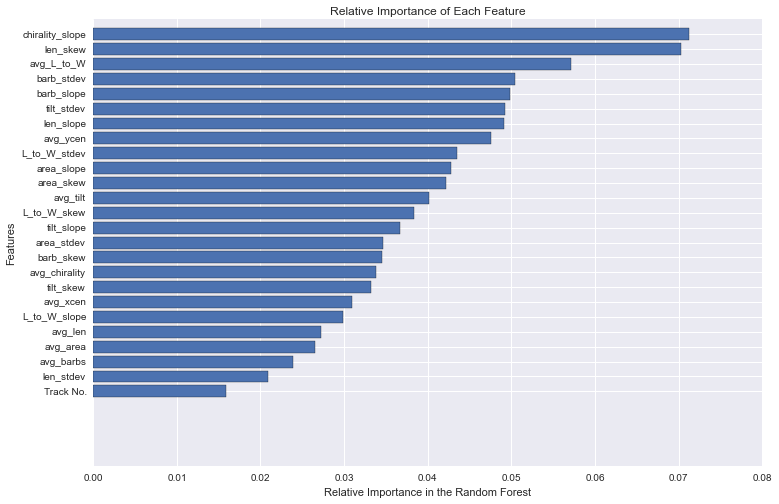

In [39]:
#Whitch features are most useful for prediction?
plt.figure(figsize=(12,8))
clf = RandomForestClassifier(n_estimators=15)

clf.fit(X,Y)
importance_list = clf.feature_importances_
name_list = all_eruptions.columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative Importance of Each Feature')
plt.show()

In [41]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.linear_model
import sklearn.svm

def plot_decision_surface(clf, X_train, Y_train):
    plot_step=0.1
    
    if X_train.shape[1] != 2:
        raise ValueError("X_train should have exactly 2 columnns!")
    
    x_min, x_max = X_train[:, 0].min() - plot_step, X_train[:, 0].max() + plot_step
    y_min, y_max = X_train[:, 1].min() - plot_step, X_train[:, 1].max() + plot_step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    clf.fit(X_train,Y_train)
    if hasattr(clf, 'predict_proba'):
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])    
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Reds)
    plt.scatter(X_train[:,0],X_train[:,1],c=Y,cmap=plt.cm.Paired)
    plt.show()

In [42]:
#Look at the predictions.
#eruptions_subset = all_eruptions[['tilt_slp','area_slp']].as_matrix()


#subset_forest = sklearn.ensemble.RandomForestClassifier(n_estimators = 15)
#fitted_subset = subset_forest.fit(eruptions_subset, Y)
#subset_val_score = cross_val_score(subset_forest, X=wine_subset, y=Y, cv=10)
#plt.title('Random Forest Decision Tree Surface')
#plot_decision_surface(fitted_subset, eruptions_subset, Y)

In [43]:
#eruptions_subset = all_eruptions[['fi_tilt_avg','fi_area_avg']].as_matrix()


#subset_forest = sklearn.ensemble.RandomForestClassifier(n_estimators = 15)
#fitted_subset = subset_forest.fit(eruptions_subset, Y)
#subset_val_score = cross_val_score(subset_forest, X=wine_subset, y=Y, cv=10)
#plt.title('Random Forest Decision Tree Surface')
#plot_decision_surface(fitted_subset, eruptions_subset, Y)

/usr/local/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


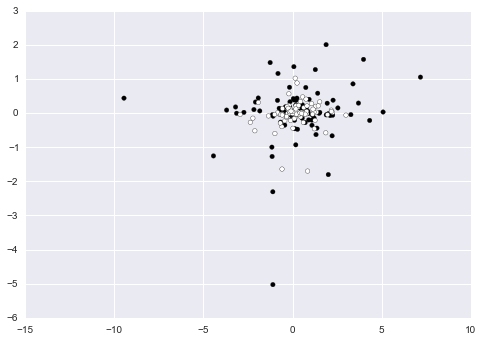

In [44]:
colors = Y
plt.scatter(all_eruptions['tilt_slope'],all_eruptions['area_slope'], c=colors)

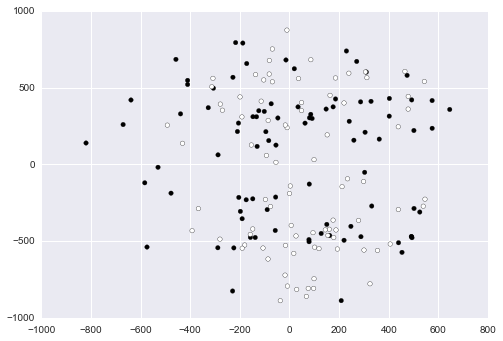

In [46]:
colors = Y
plt.scatter(all_eruptions['avg_xcen'],all_eruptions['avg_ycen'], c=colors)

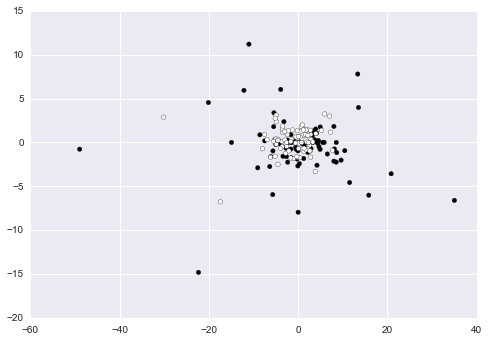

In [47]:
colors = Y
plt.scatter(all_eruptions['barb_slope'],all_eruptions['chirality_slope'], c=colors)

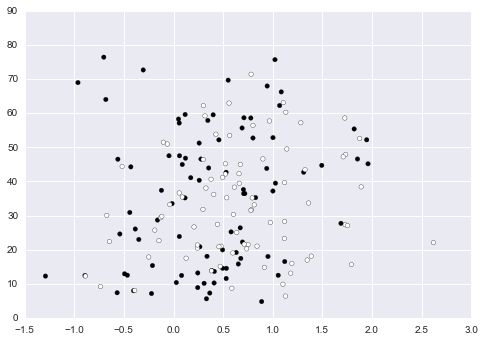

In [48]:
colors = Y
plt.scatter(all_eruptions['len_skew'],all_eruptions['tilt_stdev'], c=colors)

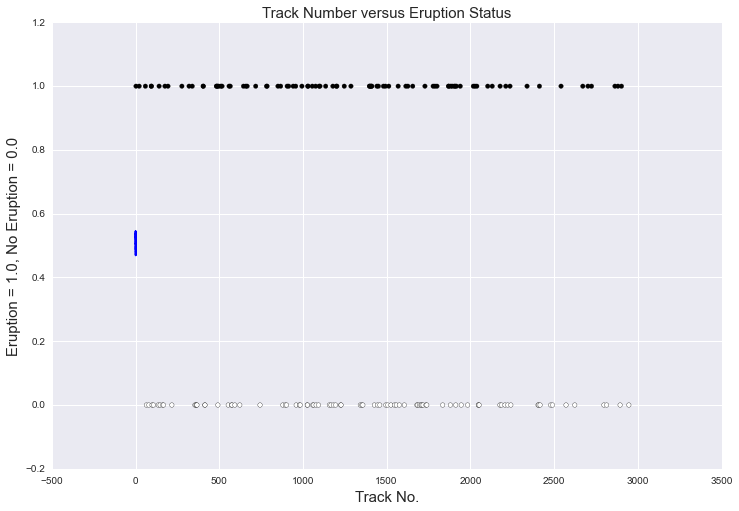

In [49]:
area_slp_X=all_eruptions['area_slope']
clf = linear_model.LinearRegression()
plt.figure(figsize=(12,8))
colors = Y
plt.scatter(all_eruptions['Track No.'], Y, c=colors)
plt.title('Track Number versus Eruption Status', fontsize = 15)
plt.ylabel('Eruption = 1.0, No Eruption = 0.0', fontsize = 15)
plt.xlabel('Track No.', fontsize = 15)
clf.fit(all_eruptions['Track No.'][:,np.newaxis],Y)
plt.plot(area_slp_X, clf.predict(all_eruptions['Track No.'][:,np.newaxis]), color='blue')

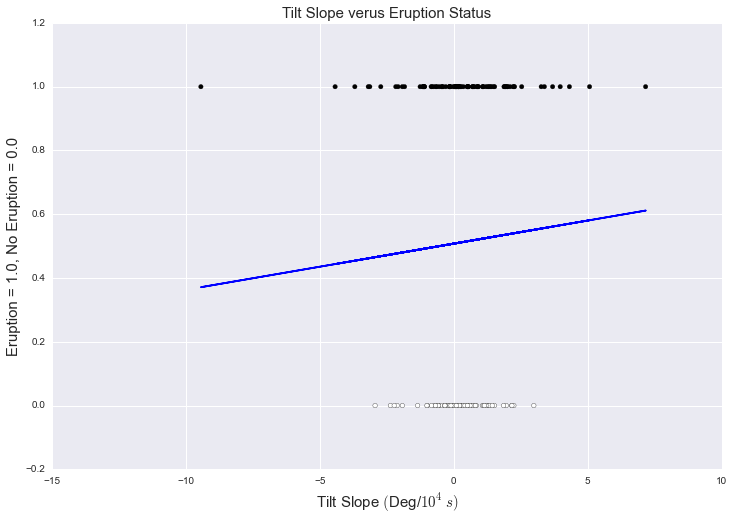

In [50]:
from sklearn import datasets
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
clf = linear_model.LinearRegression()
tilt_slp_X = np.array(all_eruptions['tilt_slope'])
plt.figure(figsize=(12,8))
colors = Y
plt.scatter(tilt_slp_X, Y, c=colors)
#clf = Ridge(alpha=1.0)
#clf = linear_model.LogisticRegression(C=1e3)
clf = linear_model.LinearRegression()
clf.fit(tilt_slp_X[:,np.newaxis],Y)
plt.clf()
plt.scatter(tilt_slp_X, Y, c=colors)
plt.plot(tilt_slp_X, clf.predict(tilt_slp_X[:,np.newaxis]), color='blue')
#plt.xlim(0,.05)
#print Y
#print all_eruptions['area_slp']
plt.title('Tilt Slope verus Eruption Status', fontsize = 15)
plt.xlabel(r'Tilt Slope $($Deg/$10^4s)$', fontsize = 15)
plt.ylabel('Eruption = 1.0, No Eruption = 0.0', fontsize = 15)
plt.figure(figsize=(12,8))
Y_predict = clf.predict(tilt_slp_X[:,np.newaxis])
#fig.gca().set_xlabel(r'wavelength $5000 \AA$')

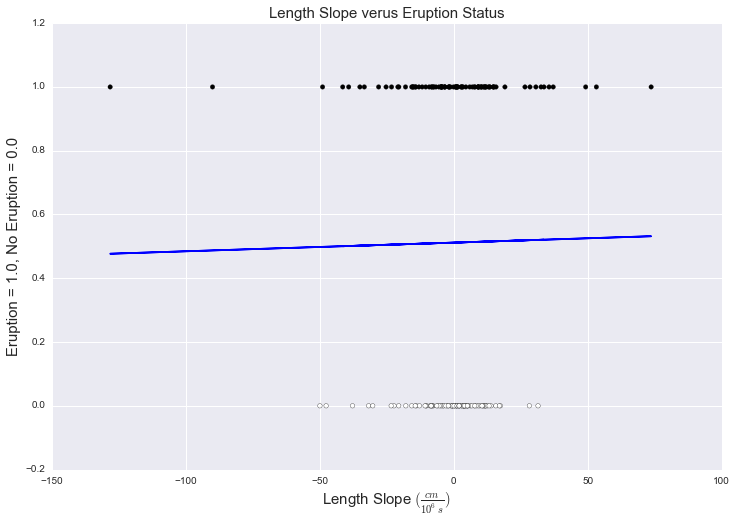

In [51]:
clf = linear_model.LinearRegression()
length_slp_X = np.array(all_eruptions['len_slope'])
plt.figure(figsize=(12,8))
colors = Y
plt.scatter(length_slp_X, Y, c=Y)
clf.fit(length_slp_X[:,np.newaxis],Y)
plt.plot(length_slp_X, clf.predict(length_slp_X[:,np.newaxis]), color='blue')
#plt.xlim(0,.05)
#print Y
#print all_eruptions['area_slp']
plt.title('Length Slope verus Eruption Status', fontsize = 15)
plt.xlabel(r'Length Slope $(\frac{cm}{10^6s})$', fontsize = 15)
plt.ylabel('Eruption = 1.0, No Eruption = 0.0', fontsize = 15)
plt.grid(True)
plt.show()

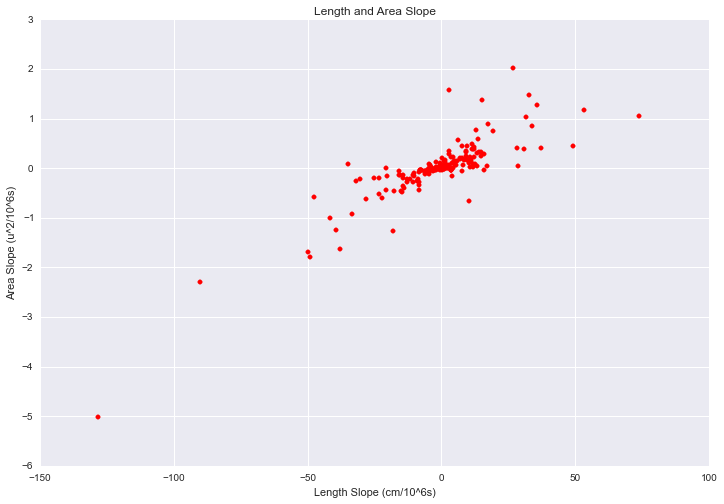

In [52]:
#clf = linear_model.LinearRegression()
length_slp_X = np.array(all_eruptions['len_slope'])
area_slp_X = np.array(all_eruptions['area_slope'])
plt.figure(figsize=(12,8))
plt.scatter(length_slp_X, area_slp_X, color='red')
#clf.fit(length_slp_X[:,np.newaxis],Y)
#plt.plot(length_slp_X, clf.predict(length_slp_X[:,np.newaxis]), color='blue')
#plt.xlim(0,.05)
#print Y
#print all_eruptions['area_slp']
plt.title('Length and Area Slope')
plt.xlabel('Length Slope (cm/10^6s)')
plt.ylabel('Area Slope (u^2/10^6s)')
plt.grid(True)
plt.show()

# Taking out the data that doesn't seem to contribute

In [56]:
good_eruptions = all_eruptions.drop(['Track No.', 'avg_barbs', 'avg_area','avg_len','len_stdev','L_to_W_slope','avg_xcen'], 1)

In [57]:

X_2 = good_eruptions.as_matrix()
print X_2

[[ -3.31884718e+00   3.31921811e-01  -5.00826738e-02 ...,   2.52894838e+00
    5.15202369e-01  -4.38115396e-01]
 [ -3.30115101e+00   7.78914026e-01  -4.13430582e-02 ...,   7.77862292e-01
    3.70525916e-01   5.05927719e-01]
 [ -1.42428926e+01   5.32747519e-01  -3.54641707e-01 ...,   7.13528410e-01
    2.58047689e-01   3.81962761e-01]
 ..., 
 [ -8.45597744e+00   5.22951265e-01  -2.87999321e-01 ...,   1.53128824e+00
    6.61342203e-01   8.18583878e-02]
 [  5.10611378e+00   4.05314886e-01   1.17620197e-01 ...,   1.02138253e+00
    1.88466573e-01   2.08099445e-01]
 [  2.01665744e+00   5.97688158e-01  -3.22145325e-03 ...,   1.21940005e+00
    1.48454490e-01  -2.52342979e-01]]


# rerunning the random forest classifier

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score

n_trees = [15]*40 #Again, each forest will have 15 trees
scores = []
for i in n_trees:
    forest = sklearn.ensemble.RandomForestClassifier(n_estimators = i)
    val_score = cross_val_score(forest, X=X_2, y=Y, cv=10)
    scores.append(val_score) 

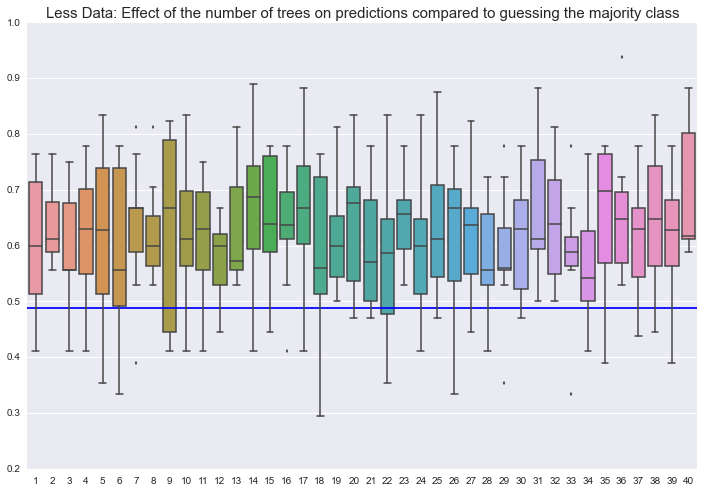

In [60]:
plt.figure(figsize=(12,8))
plt.axhline(y=avg)
plt.title('Less Data: Effect of the number of trees on predictions compared to guessing the majority class', fontsize=15)
#sns.boxplot(data=scores)
sns.boxplot(scores)

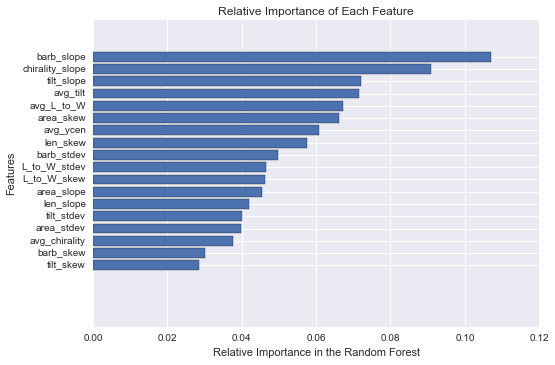

In [61]:
#Whitch features are most useful for prediction?
clf = RandomForestClassifier(n_estimators=15)
clf.fit(X_2,Y)
importance_list = clf.feature_importances_
name_list = good_eruptions.columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative Importance of Each Feature')
plt.show()